### Weather impacts life each and every day in both relatively minor and significant ways. Many people check the weather daily to know what the predicted temperature and precipitation will be so they can plan how to dress, what activities to do, and how early to leave on their daily commute.



###This program predicts the weather at different points of time

---

In [ ]:
!apt-get install openjdk-8-jdk-headless openjdk-8-jdk-headless -qq > /dev/null
!pip install -q findspark
!pip install pyspark
!pip install py4j
!pip install pyarrow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "2") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .getOrCreate()

df = spark.read.csv("/content/drive/MyDrive/Fall\'24/CSCI4521/hw4/weather_csci4521_hw4.csv", header = True)
df = df.repartition(2)

print("Number of samples: ", df.count())
print("Number of features: ", len(df.columns) -1)

df.show(10)

Number of samples:  96453
Number of features:  108
+--------------------+------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+---------+---------+-------------------+----------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+----------+-------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+-------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+----------

# Cleaning the Data

## Cast numerical data to float

In [ ]:
from pyspark.sql.functions import col
numerical_columns = [col_name for col_name in df.columns if col_name not in ["Daily Summary","Formatted Date"]]

for c in df.columns:
  if c in numerical_columns:
    df = df.withColumn(c, col(c).cast("float"))

## Remove duplicate samples

In [ ]:
from pyspark.sql.functions import count

# Group by all columns and count occurrences
df_grouped = df.groupBy(df.columns).count()

# Filter for rows where count is greater than 1 (duplicates)
duplicate_rows = df_grouped.filter(df_grouped["count"] > 1)

# If duplicate_rows is not empty, there are duplicates
if duplicate_rows.count() > 0:
  # Remove duplicates using dropDuplicates()
  df_no_duplicates = df.dropDuplicates()
  num_duplicates_removed = df.count() - df_no_duplicates.count()
  print("Number of duplicate samples removed:", num_duplicates_removed)
  print("Number of rows after removing duplicates:", df_no_duplicates.count())

  # Update dataframe
  df = df_no_duplicates

else:
  print("No duplicate samples found.")

Number of duplicate samples removed: 241
Number of rows after removing duplicates: 96212


## Replace missing values

In [ ]:
from pyspark.sql.functions import isnan, when, count, median, col
from pyspark.sql import functions as F, DataFrame

def calculate_null_counts(df: DataFrame, include_columns=None) -> tuple:
    """
    Counts the number of null values for each specified column in the DataFrame.

    Parameters:
    ----------
    df : DataFrame
        The Spark DataFrame containing the data to analyze.
    include_columns : list of str, optional
        List of column names to include in the null count analysis.
        If None, all columns in `df` are included.

    Returns:
    -------
    DataFrame
        A DataFrame with columns representing each specified column in `df` and
        rows containing the count of null values for each column.
    """
    # If include_columns is not specified, default to all columns in df
    if include_columns is None:
        include_columns = df.columns

    # Count null values for each column
    null_counts = df.select([F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns])

    return null_counts

def calculate_median(df: DataFrame, include_columns=None) -> dict:
    """
    Calculates the approximate median for each specified column in the DataFrame.

    Parameters:
    ----------
    df : DataFrame
        The Spark DataFrame containing the data to analyze.
    include_columns : list of str, optional
        List of column names to calculate the median for.
        If None, all columns in `df` are included.

    Returns:
    -------
    dict
        A dictionary where keys are column names and values are the approximate median
        of each column based on the `approxQuantile` function with a relative error of 0.01.
    """
    # If include_columns is not specified, default to all columns in df
    if include_columns is None:
        include_columns = df.columns

    # Calculate approximate median for all columns at once
    quantiles = df.approxQuantile(include_columns, [0.5], 0.01)  # 0.01 is the relative error

    # Map each column to its respective median value
    median_dict = {col_name: quantiles[i][0] for i, col_name in enumerate(include_columns)}

    return median_dict

print("Before replacement")
df.show(10)

feature_column_list = [col_name for col_name in df.columns if col_name != "Temperature (C)"]

# Dataframe of feature columns
feature_column = df.select(feature_column_list)

null_counts_df = calculate_null_counts(df, include_columns=feature_column_list)
# null_counts_df.show()  # Show the DataFrame with null counts for each column

# Excludes string columns
calc_median_column_list = [col_name for col_name in df.columns if col_name not in ["Daily Summary","Formatted Date"]]

# Calculate median and store in dictionary
median = calculate_median(df, include_columns=calc_median_column_list)

df = df.fillna(median)

# Remove feature 17 because it only contains 0
df = df.drop("feature_17")

print("")
print("After replacement")
df.show(10)

Before replacement
+--------------------+------------+----------+----------+----------+----------+----------+---------+---------+---------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+-----------+-----------+----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+-----------+-----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----

## Feature Engineering

### Extracting data features from feature "Formatted Date"

In [ ]:
from pyspark.sql.functions import col, year, month, dayofmonth, dayofweek, hour, when, expr


# Convert 'Formatted Date' to timestamp
df = df.withColumn('Formatted Date', expr("to_timestamp(`Formatted Date`, 'yyyy-MM-dd HH:mm:ss.SSS Z')"))

# Extracting date features from 'Formatted 'Date'
df = df.withColumn('Year', year(col('Formatted Date'))) \
       .withColumn('Month', month(col('Formatted Date'))) \
       .withColumn('Day', dayofmonth(col('Formatted Date'))) \
       .withColumn('Day of Week', dayofweek(col('Formatted Date'))) \
       .withColumn('Quarter', expr('quarter(`Formatted Date`)')) \
       .withColumn('Hour', hour(col('Formatted Date'))) \
       .withColumn('Is Weekend', when(col('Day of Week') >= 7, 1).otherwise(0))  # 1 if Saturday (7) or Sunday (1)

df = df.drop("Formatted Date")

### Extracting data features from feature "Daily Summary"

In [ ]:
from pyspark.sql.functions import col, lower, when, size, split, regexp_replace

# Convert to lowercase
df = df.withColumn('Daily Summary', lower(col('Daily Summary')))

# Define weather conditions to create binary features
conditions = ['foggy', 'cloudy', 'overcast', 'partly cloudy', 'breezy', 'rain', 'windy', 'drizzle']

# Create binary columns for each weather condition
for condition in conditions:
    df = df.withColumn(condition, when(col('Daily Summary').contains(condition), 1).otherwise(0))

df.show(10)

+------------+----------+----------+----------+----------+----------+---------+---------+---------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+-----------+-----------+----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+-----------+-----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------

## Ordinal Encoding Categorical Columns

In [ ]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCols=["Daily Summary", "Year", "Month", "Day", "Day of Week", "Quarter", "Hour"],
                        outputCols=["Daily Summary Index", "Year Index", "Month Index", "Day Index", "Day of Week Index", "Quarter Index", "Hour Index"])

df = indexer.fit(df).transform(df)
df = df.drop(*["Daily Summary","Formatted Date", "Year", "Month", "Day", "Day of Week", "Quarter", "Hour"])

df.show(10)

+------------+----------+----------+----------+----------+----------+---------+---------+---------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+-----------+-----------+----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+-----------+-----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------

## Removing Outliers

In [ ]:
from typing import List
from pyspark.sql import DataFrame
from pyspark.sql import functions as F
import functools

def identify_outliers(df: DataFrame, feature_columns: List[str], lower: List[float], upper: List[float]) -> List[int]:
    """
    Identifies outliers in specified feature columns of a PySpark DataFrame based on provided lower and upper bounds.

    Parameters:
    - df: DataFrame containing the data.
    - feature_columns: List of column names to check for outliers (should be numeric).
    - lower: List of lower bounds for each feature column.
    - upper: List of upper bounds for each feature column.

    Returns:
    - List of row indices containing outliers.
    """
    # Initialize a filter condition for each feature's outlier bounds
    # Column level filtering with conditions, avoids row by row iteration
    conditions = [
        (F.col(feature) < lower_bound) | (F.col(feature) > upper_bound)
        for feature, lower_bound, upper_bound in zip(feature_columns, lower, upper)
    ]

    # Combine all conditions with OR to flag any outliers in any feature column
    # Use functools.reduce with an initial value of False
    # Merges all conditions into a single logical expression, allows PySpark to apply
    # filtering in one pass across the df rather than separately for each column
    outlier_condition = functools.reduce(lambda a, b: a | b, conditions, F.lit(False))

    # Filter and select only the rows that contain outliers
    outliers_df = df.withColumn("row_index", F.monotonically_increasing_id()).filter(outlier_condition)

    # Collect the row indices with outliers
    outlier_indices = [row.row_index for row in outliers_df.select("row_index").collect()]
    return outlier_indices

def remove_outliers(df: DataFrame, outlier_indices: List[int]) -> DataFrame:
    """
    Removes rows from the DataFrame that contain outliers based on specified row indices.

    Parameters:
    - df: The original DataFrame.
    - outlier_indices: List of row indices that contain outliers.

    Returns:
    - DataFrame with outliers removed.
    """
    # Broadcast outlier indices for efficient filtering
    # distribute the list of indices across all nodes in the cluster,
    # making it accessible without repeated data transfer.
    broadcast_outliers = spark.sparkContext.broadcast(set(outlier_indices))

    # Add a row index column and filter out rows with outlier indices
    df_filtered = (
        df.withColumn("row_index", F.monotonically_increasing_id())
          .filter(~F.col("row_index").isin(broadcast_outliers.value))
          .drop("row_index")
    )

    return df_filtered

In [ ]:
print("Number of samples before removing outliers: ", df.count())

categorical_label_columns = ["Daily Summary Index", "Year Index", "Month Index", "Day Index", "Day of Week Index", "Quarter Index", "Hour Index", "Temperature (C)"]

# List of numerical feature columns
feature_columns = [col_name for col_name in df.columns if col_name not in categorical_label_columns]

# Calculate mean and stddev for each numerical column
stats = df.select([F.mean(c).alias(f"{c}_mean") for c in feature_columns] +
                  [F.stddev(c).alias(f"{c}_std") for c in feature_columns]).collect()[0]

# Calculate lower and upper bounds for each feature based on 3 * stddev
lower = [stats[f"{col}_mean"] - (3 * stats[f"{col}_std"]) for col in feature_columns]
upper = [stats[f"{col}_mean"] + (3 * stats[f"{col}_std"]) for col in feature_columns]

# Identify and remove outliers
outliers = identify_outliers(df, feature_columns, lower, upper)
df_filtered = remove_outliers(df, outliers)
print(f"Number of outliers: {len(outliers)}")
df = df_filtered
print("Number of samples after removing outliers: ", df.count())


Number of samples before removing outliers:  96212
Number of outliers: 10622
Number of samples after removing outliers:  85590


## Standardize the data

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, udf, lit, stddev, mean, col
from pyspark.sql.types import ArrayType, FloatType

def convert_df_to_dense_vector(df: DataFrame, features_to_standardize) -> DataFrame:
    """
    Converts specified columns of a DataFrame into a dense vector representation.

    Parameters:
    -----------
    df : DataFrame
        The input DataFrame containing numeric data to be vectorized.

    features_to_standardize : list
        A list of column names to include in the dense vector. These columns are combined
        into a single feature vector.

    Returns:
    --------
    DataFrame
        A DataFrame with an added column "vec_feats" containing dense vectorized
        representations of the specified columns.

    Notes:
    ------
    - All columns specified in `features_to_standardize` should be numeric.
    - VectorAssembler may output sparse vectors when data is sparse.
    """
    # Vector assembler returns both dense and sparse vectors. Sparse vectors will have output as: (size, indices, values)
    vec_assembler = VectorAssembler(inputCols = features_to_standardize, outputCol="vec_feats")
    df_vec = vec_assembler.transform(df)

    return df_vec

def standardize_data(df, features_to_standardize):
  """
  Standardizes the given numerical features in a PySpark DataFrame.

  Args:
    df: The PySpark DataFrame containing the data.
    features_to_standardize: A list of column names representing the numerical
                             features to be standardized.

  Returns:
    A new PySpark DataFrame with a new column "scaled_features" containing
    the standardized feature vector.
  """

  # Create a VectorAssembler to combine the features into a single vector column
  df_assembled = convert_df_to_dense_vector(df,features_to_standardize)

  # Create a StandardScaler object
  scaler = StandardScaler(inputCol="vec_feats", outputCol="scaled_features", withStd=True, withMean=True)

  # Fit the scaler to the data and transform the data
  scaler_model = scaler.fit(df_assembled)
  df_scaled = scaler_model.transform(df_assembled)

  return df_scaled

def expand_dense_vector_to_columns(df: DataFrame, dense_vector_col: str = "scaled_features", exclude_cols=None) -> DataFrame:
    """
    Expands a DenseVector column into individual feature columns in a DataFrame.

    Parameters:
    -----------
    df : DataFrame
        The input DataFrame containing the dense vector column.

    dense_vector_col : str, optional
        The name of the column containing the DenseVector to expand (default is "scaled_features").

    exclude_cols : list, optional
        A list of column names to exclude from the expansion. Defaults to ['vec_feats', 'scaled_features'].

    Returns:
    --------
    DataFrame
        A DataFrame with individual columns for each element in the DenseVector, and the DenseVector column removed.
    """

    # Set default columns to exclude if none provided
    if exclude_cols is None:
        exclude_cols = ['vec_feats', 'scaled_features']

    # Get feature names (all columns except those in exclude_cols)
    columns = [col_name for col_name in df.columns if col_name not in exclude_cols]

    # Define UDF to convert DenseVector to ArrayType (list of floats)
    vector_to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))

    # Convert the DenseVector column to an array
    df = df.withColumn("scaled_features_array", vector_to_array(df[dense_vector_col]))

    # Expand the array elements into individual columns
    for i, feature_name in enumerate(columns):
        df = df.withColumn(feature_name, col("scaled_features_array")[i])

    # Drop the intermediate and original DenseVector columns
    df = df.drop("scaled_features_array", dense_vector_col, "vec_feats")

    return df


In [ ]:
import matplotlib.pyplot as plt

print("Dataframe before standardizing:")
df.show(10)


categorical_label_columns = ["Daily Summary Index", "Year Index", "Month Index", "Day Index", "Day of Week Index", "Quarter Index", "Hour Index", "Temperature (C)"]

numerical_column_list = [col_name for col_name in df.columns if col_name not in categorical_label_columns]
exclude_columns = ["vec_feats", "scaled_features"]

exclude_columns = exclude_columns + categorical_label_columns

scaled_data = standardize_data(df, numerical_column_list)
scaled_data = expand_dense_vector_to_columns(scaled_data, exclude_cols=exclude_columns)

df = scaled_data

print("")
print("Dataframe after standardizing:")
df.show(10)

Dataframe before standardizing:
+------------+----------+----------+----------+----------+----------+---------+---------+---------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+-----------+-----------+----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+-----------+-----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+

## Feature selection

In [ ]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from typing import Tuple

def select_features(
    X: np.ndarray,
    y: np.ndarray,
    num_features: int,
    score_func: str
) -> Tuple[np.ndarray, SelectKBest]:
    """
    Selects the top `num_features` from `X` based on the scoring function `score_func`.

    Parameters:
        X (np.ndarray): The feature matrix.
        y (np.ndarray): The target vector.
        num_features (int): Number of features to select.
        score_func (str): Scoring function to use ('f_regression' or 'mutual_info_regression').

    Returns:
        Tuple[np.ndarray, SelectKBest]: The transformed feature matrix with selected features, and the fitted SelectKBest instance.
    """
    if score_func == "f_regression":
        # f_regression to compute F-value between each feature and target
        # suitable for linear regression problems and numerical data
        fs = SelectKBest(score_func=f_regression, k=num_features)
    elif score_func == "mutual_info_regression":
        # mutual_info_regression measures dependence between two variables (feature and target)
        # suitable for non-linear regression problems and categorical/mixed data
        fs = SelectKBest(score_func=mutual_info_regression, k=num_features)
    else:
        raise ValueError(f"Unknown score function: {score_func}. Available functions: f_regression, mutual_info_regression.")

    fs.fit(X, y)
    X_fs = fs.transform(X)
    return X_fs, fs

### f_regression

f_regression feature scores:
Feature feature_0: 1.1742593175845115
Feature feature_1: 0.029887989684423424
Feature feature_2: 0.09462107862429935
Feature feature_3: 0.10831195122346864
Feature feature_4: 1.1748913985725142
Feature feature_5: 2.479405186144586
Feature feature_6: 0.03985562134527864
Feature feature_7: 10910.498631313523
Feature feature_8: 53271.979905395754
Feature feature_9: 0.08494901461775457
Feature feature_10: 67.3709963660161
Feature feature_11: 2.3733917667162534
Feature feature_12: 0.4787365804756293
Feature feature_13: 1.8281799369615859
Feature feature_14: 0.32333443538600737
Feature feature_15: 0.3772512026920054
Feature feature_16: 3.2584663265436014
Feature feature_18: 0.566458692753794
Feature feature_19: 17437.70624979144
Feature feature_20: 0.8636864668988669
Feature feature_21: 1.5674874618830723
Feature feature_22: 0.009081871882675209
Feature feature_23: 0.8784028055641906
Feature feature_24: 0.055517999112589436
Feature feature_25: 0.03285377760299111

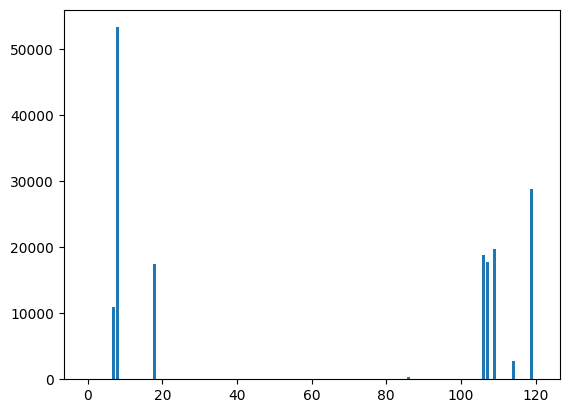

In [ ]:
# Convert spark df to pandas df
pandas_df = df.toPandas()

numerical_features = [col_name for col_name in df.columns if col_name != "Temperature (C)"]

numerical_df = pandas_df[numerical_features]

# Convert to ndarray
numerical_rows_narray = numerical_df.values # rows

label_narray = pandas_df["Temperature (C)"].values

X = numerical_rows_narray
y = label_narray

num_features_to_select = 70

# Feature selection with anova
X_feat, fs = select_features(X, y, num_features_to_select, "f_regression")

features_to_keep = []

# Print feature scores
print("f_regression feature scores:")
for i in range(len(fs.scores_)):
    print(f"Feature {numerical_features[i]}: {fs.scores_[i]}")

    if fs.scores_[i] > 1:
      features_to_keep.append(numerical_features[i])

print("")
print(f"Number of features to keep (excluding label): {len(features_to_keep)}")

features_to_keep.append("Temperature (C)")

# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [ ]:
# drop features
selected_df = df.drop(*[col_name for col_name in df.columns if col_name not in features_to_keep])
selected_df = selected_df.toPandas()
selected_df.head(n=10)

,feature_0,feature_4,feature_5,feature_7,feature_8,feature_10,feature_11,feature_13,feature_16,feature_19,...,Is Weekend,foggy,cloudy,partly cloudy,Daily Summary Index,Year Index,Month Index,Day Index,Quarter Index,Hour Index
0,-0.644080,-1.463964,-1.015650,-0.838384,0.703686,0.918665,-1.122036,0.913845,-0.908931,0.881000,...,-0.403772,-0.519534,0.533164,1.106436,21.0,6.0,2.0,11.0,2.0,15.0
1,0.032698,-1.691328,1.377460,0.126131,1.020818,0.575582,0.881305,0.571593,-1.696547,0.078123,...,-0.403772,-0.519534,0.533164,-0.903792,0.0,8.0,4.0,9.0,3.0,16.0
2,-0.060367,-0.568167,-0.879850,-0.031013,-2.520489,-0.238015,-1.144823,0.639031,-0.350816,-0.089301,...,-0.403772,-0.519534,0.533164,1.106436,6.0,6.0,0.0,18.0,0.0,14.0
3,-1.594888,1.474395,-0.037357,-0.217954,-0.987684,-0.061572,-0.230208,-1.318739,-0.167799,1.086475,...,-0.403772,-0.519534,0.533164,1.106436,70.0,3.0,2.0,6.0,2.0,15.0
4,-1.328881,0.521157,1.447516,-0.380514,1.179384,-0.061572,-1.159442,-1.011141,1.708948,1.075060,...,-0.403772,-0.519534,0.533164,1.106436,2.0,0.0,10.0,17.0,2.0,23.0
5,-0.143967,1.292757,-0.308895,0.775003,-0.300565,1.183329,-1.509556,-0.083089,-0.162674,1.170187,...,-0.403772,-0.519534,0.533164,1.106436,6.0,4.0,6.0,4.0,0.0,18.0
6,-0.009493,-0.084973,-1.156709,1.560704,1.020818,-1.326077,0.117069,-1.691437,0.603257,-2.239183,...,-0.403772,1.924778,-1.875573,-0.903792,4.0,6.0,5.0,24.0,1.0,12.0
7,0.227085,0.589568,0.005219,-0.610797,1.020818,1.595028,0.275805,-1.604870,-0.008119,1.075060,...,-0.403772,-0.519534,0.533164,1.106436,1.0,4.0,2.0,22.0,2.0,5.0
8,-0.689225,1.311688,0.649105,1.227450,1.179384,-1.718172,1.548968,-0.026263,0.466187,-2.345726,...,-0.403772,-0.519534,0.533164,1.106436,9.0,4.0,9.0,9.0,0.0,11.0
9,-1.429110,-0.159423,-0.226393,0.188439,0.016567,-0.061572,-0.272185,1.563884,-1.480393,0.215107,...,-0.403772,-0.519534,0.533164,-0.903792,0.0,4.0,6.0,0.0,0.0,13.0


## Dataframe going into training model

In [ ]:
num_samples, num_features = selected_df.shape
print(f"Number of samples: {num_samples}")
print(f"Number of features: {num_features - 1}") # excludes the label

Number of samples: 85590
Number of features: 43


---

# Training Regression Models

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error


## Split the data into 80/20

In [ ]:
X = selected_df.drop(columns=['Temperature (C)'])
y = selected_df['Temperature (C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

## Standard Linear Regression (Least Squares)

In [ ]:
# Initialize and train Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Predict on test set
y_pred_lr = linear_reg.predict(X_test)

# Evaluate performance
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = root_mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression - MAE: {mae_lr:.2f}, RMSE: {rmse_lr:.2f}, R^2: {r2_lr:.2f}")


Linear Regression - MAE: 4.33, RMSE: 5.48, R^2: 0.68


## Ridge Regression

In [ ]:
# Define parameter grid
ridge_params = {'alpha': [0.1, 1, 10, 100]}

# Use GridSearchCV for hyperparameter tuning
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_root_mean_squared_error', return_train_score = True)
ridge_cv.fit(X_train, y_train)

print("*" * 40)
# Display results
for mean_train, mean_test, params in zip(
        ridge_cv.cv_results_['mean_train_score'],
        ridge_cv.cv_results_['mean_test_score'],
        ridge_cv.cv_results_['params']):
    print(f"Params: {params}")
    print(f"Training Score: {-mean_train:.4f}")
    print(f"Validation Score: {-mean_test:.4f}")
    print("*" * 40)

# Predict and evaluate
best_ridge = ridge_cv.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = root_mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Ridge Regression - Best alpha: {ridge_cv.best_params_['alpha']}")
print()
print("Testing model with best hyperparameter:")
print(f"Ridge Regression - MAE: {mae_ridge:.2f}, RMSE: {rmse_ridge:.2f}, R^2: {r2_ridge:.2f}")

****************************************
Params: {'alpha': 0.1}
Training Score: 5.4752
Validation Score: 5.4811
****************************************
Params: {'alpha': 1}
Training Score: 5.4752
Validation Score: 5.4811
****************************************
Params: {'alpha': 10}
Training Score: 5.4752
Validation Score: 5.4811
****************************************
Params: {'alpha': 100}
Training Score: 5.4752
Validation Score: 5.4811
****************************************
Ridge Regression - Best alpha: 100

Testing model with best hyperparameter:
Ridge Regression - MAE: 4.33, RMSE: 5.48, R^2: 0.68


## Lasso Regression

In [ ]:
# Define parameter grid
lasso_params = {'alpha': [0.01, 0.1, 1, 10]}

# Use GridSearchCV for hyperparameter tuning
lasso = Lasso(max_iter=10000)
lasso_cv = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_root_mean_squared_error', return_train_score = True)
lasso_cv.fit(X_train, y_train)

print("*" * 40)
# Display results
for mean_train, mean_test, params in zip(
        lasso_cv.cv_results_['mean_train_score'],
        lasso_cv.cv_results_['mean_test_score'],
        lasso_cv.cv_results_['params']):
    print(f"Params: {params}")
    print(f"Training Score: {-mean_train:.4f}")
    print(f"Validation Score: {-mean_test:.4f}")
    print("*" * 40)


# Predict and evaluate
best_lasso = lasso_cv.best_estimator_
y_pred_lasso = best_lasso.predict(X_test)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
rmse_lasso = root_mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Lasso Regression - Best alpha: {lasso_cv.best_params_['alpha']}")

print()
print("Testing model with best hyperparameter:")
print(f"Lasso Regression - MAE: {mae_lasso:.2f}, RMSE: {rmse_lasso:.2f}, R^2: {r2_lasso:.2f}")


****************************************
Params: {'alpha': 0.01}
Training Score: 5.4760
Validation Score: 5.4805
****************************************
Params: {'alpha': 0.1}
Training Score: 5.4828
Validation Score: 5.4845
****************************************
Params: {'alpha': 1}
Training Score: 5.8000
Validation Score: 5.8012
****************************************
Params: {'alpha': 10}
Training Score: 9.5703
Validation Score: 9.5703
****************************************
Lasso Regression - Best alpha: 0.01

Testing model with best hyperparameter:
Lasso Regression - MAE: 4.33, RMSE: 5.48, R^2: 0.68


## Random Forest Regressor

### Cross validatating num trees

In [ ]:
num_trees_vals = [10, 25, 50]

for num_trees in num_trees_vals:
    rf = RandomForestRegressor(n_estimators = num_trees, random_state=42)
    scores = cross_val_score(rf, X_train, y_train, cv=10)
    print(f"Results for num_tree = {num_trees}")
    print(f"Accuracy per fold: {scores}")
    print(f"Average accuracy and standard deviation: {scores.mean()} ({scores.std()})")
    print("")

Results for num_tree = 10
Accuracy per fold: [0.90155457 0.89277505 0.89876356 0.89645243 0.89508266 0.89930633
 0.89558811 0.90047327 0.89526864 0.89799349]
Average accuracy and standard deviation: 0.8973258106360769 (0.002607291780643033)

Results for num_tree = 25
Accuracy per fold: [0.90974351 0.89895268 0.90654196 0.90409847 0.90308342 0.90875356
 0.9048394  0.90774733 0.9031468  0.90607747]
Average accuracy and standard deviation: 0.9052984607445891 (0.003021621804694214)

Results for num_tree = 50
Accuracy per fold: [0.91249842 0.90323128 0.90907796 0.9074015  0.90519063 0.91110393
 0.90724801 0.90964395 0.9067975  0.9095166 ]
Average accuracy and standard deviation: 0.9081709775027982 (0.0026219342710571544)



### Testing the trained model

In [ ]:
# Use GridSearchCV for hyperparameter tuning
rf = RandomForestRegressor(n_estimators = 50, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}, R^2: {r2_rf:.2f}")


Random Forest - MAE: 2.19, RMSE: 2.91, R^2: 0.91


## Gradient Boosting Regressor

## Tune hyperparameters using GridSearchCV

In [ ]:
# Define parameter grid
gb_params = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}

# Use GridSearchCV for hyperparameter tuning
gb = GradientBoostingRegressor(random_state=42)
gb_cv = GridSearchCV(gb, gb_params, cv=5, scoring='neg_root_mean_squared_error', return_train_score = True)
gb_cv.fit(X_train, y_train)

print("*" * 40)
# Display results
for mean_train, mean_test, params in zip(
        gb_cv.cv_results_['mean_train_score'],
        gb_cv.cv_results_['mean_test_score'],
        gb_cv.cv_results_['params']):
    print(f"Params: {params}")
    print(f"Training Score: {-mean_train:.4f}")
    print(f"Validation Score: {-mean_test:.4f}")
    print("*" * 40)

# Predict and evaluate
best_gb = gb_cv.best_estimator_
y_pred_gb = best_gb.predict(X_test)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting - Best parameters: {gb_cv.best_params_}")

print()
print("Testing model with best hyperparameter:")
print(f"Gradient Boosting - MAE: {mae_gb:.2f}, RMSE: {rmse_gb:.2f}, R^2: {r2_gb:.2f}")


****************************************
Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Training Score: 6.1855
Validation Score: 6.1897
****************************************
Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Training Score: 4.9175
Validation Score: 4.9265
****************************************
Params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
Training Score: 5.3874
Validation Score: 5.3987
****************************************
Params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Training Score: 4.2256
Validation Score: 4.2506
****************************************
Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Training Score: 3.7182
Validation Score: 3.7426
****************************************
Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Training Score: 3.4588
Validation Score: 3.4973
****************************************
Params: {'lea

## Best Model

In [ ]:
# Compare and select the model with the lowest MAE and MSE and highest R^2
models_performance = {
    "Linear Regression": [mae_lr, rmse_lr, r2_lr],
    "Ridge Regression": [mae_ridge, rmse_ridge, r2_ridge],
    "Lasso Regression": [mae_lasso, rmse_lasso, r2_lasso],
    "Random Forest": [mae_rf, rmse_rf, r2_rf],
    "Gradient Boosting": [mae_gb, rmse_gb, r2_gb]
}

# Initialize variables to store the best model and its metrics
best_model = None
best_mae = float('inf')  # Lower is better for MAE
best_rmse = float('inf')
best_r2 = float('-inf')  # Higher is better for R^2

for model_name, metrics in models_performance.items():
    mae, rmse, r2 = metrics
    print(f"{model_name}: MAE={mae:.2f}, RMSE={rmse:.2f}, R^2={r2:.2f}")

    # Check if this model has better performance based on MAE, MSE, and R^2 criteria
    if (mae < best_mae and rmse < best_rmse and r2 > best_r2):
        best_model = model_name
        best_mae, best_rmse, best_r2 = mae, rmse, r2

# Print the best model
print("\nBest Model:")
print(f"{best_model}: MAE={best_mae:.2f}, RMSE={best_rmse:.2f}, R^2={best_r2:.2f}")


Linear Regression: MAE=4.33, RMSE=5.48, R^2=0.68
Ridge Regression: MAE=4.33, RMSE=5.48, R^2=0.68
Lasso Regression: MAE=4.33, RMSE=5.48, R^2=0.68
Random Forest: MAE=2.19, RMSE=2.91, R^2=0.91
Gradient Boosting: MAE=2.38, RMSE=9.18, R^2=0.90

Best Model:
Random Forest: MAE=2.19, RMSE=2.91, R^2=0.91


# **REPORT**


## Data Before Cleaning
- Number of samples:  96453
- Number of features:  108
## Cleaning Data
1. Cast numerical data to float
-  Ensures consistency in the data type in the dataset to ensure that there would not be type issues in data cleaning/processing.
2. Remove duplicate samples
- Duplicate samples were removed to avoid skewing the results of model training. If the same sample appears more than once, it can give more weight in the training process, leading to biased predictions.
- Result:
  - 241 duplicate samples were removed.
3. Replace missing values
- Missing values were removed because SelectKBest does not accept NaN values in the labels. Regression algorithms also cannot handle missing values directly, which may lead to erros during training and predictions.
- Result:
  - The missing values are replaced with the median of the respective features that they lie on, because median is resistant to outliers.
4. Drop "feature_17"
- "feature_17" was dropped becasue it only contained zero values, thus it wasn't statistically significant in training the predictive model.
5. Feature Engineering
- Extracting data features from feature "Formatted Date"
  - The "Formatted Date" column was split into 7  additional features:
    - "Year"
      - Since the data spans multiple years, adding a "Year" feature would help capture long-term changes or patterns, such as steady warming or cooling over time
    - "Month"
      - Temperatures fluctuate with season (e.g., summer vs. winter), and the month is a good predictor of seasonal fluctuations. Adding a "Month" feature enables the model to learn that July is often warmer than January, for example, potentially improving its accuracy in predicting seasonal temperatures.
    - "Day"
      - Adding a "Day" feature enables for more detailed modeling within a month, as temperature patterns might change from beginning to finish.
    - "Day of Week"
      - Temperatures might vary somewhat depending on the day of the week owing to human activity. For example, weekends may have somewhat different temperature patterns if human activity influences temperature
    - "Quarter"
      - By dividing the year into quarters (Q1, Q2, Q3, Q4), the model can broadly discriminate between seasons.
    - "Hour"
      - Temperature normally cools at night and warms throughout the day. By incorporating the hour, the model may learn diurnal temperature trends, which improves forecasts, particularly for short-term forecasting.
    - "Is Weekend"
      - Weekends can cause small shifts in temperature trends due to less urban activity, particularly in densely populated places.

  After extracting all these data features, the formatted date column would be dropped.
- Extracting data features from feature "Daily Summary"
  - Adds granularity to the dataset, which is beneficial for tree-based models such as random forests, and gradient boosting (which explains the highest performance score from both models from this dataset)
  - A model may reveal that "foggy" circumstances significantly correspond with specific temperature patterns.
  - It may also determine that "breezy" circumstances affect temperature differently depending on the time of day
6. Ordinal encoding categorical columns
- Ordinal encoding categorical columns help improve model performance. Moreover, regression algorithms like SVM and Linear Regression requires numerical input so ordinal encoding categorical columns ensure compatibility with such alogrithms, so that they can be processed effectively.
- Result:
  - "Daily Summary", "Year", "Month", "Day", "Day of Week", "Quarter", "Hour" columns now have their values represented with numerics for their respective categories.
7. Removing outliers
- The lower and upper threshold is decided based on the three-sigma limits of the empirical rule, which states that almost all observed data will fall within three standard deviations of the mean on a normal distribution (bell figure).
- Outliers were removed because outliers represent noise in the data, thus removing them can help in creating a cleaner dataset that may help with training a more accurate model.
- Result:
  - 10622 outliers removed.
8. Standardize the data
-  Features are standardized to have a standard deviation of one and a mean of zero. This keeps features with bigger sizes from controlling the model and guarantees that each feature contributes equally to the distance computations in algorithms.
- Standardizing data is useful in algorithms like logistic regression, which assume normally distributed data or use distance-based calculations.
- Result:
  - Features now have a standard deviation of one and a mean of zero.
9. Feature selection
- SelectKBest with a score function of "f_regression" is used to help identify and retain the most relevant feature in a dataset for a regression problem.
- "f_regression" calculates the F-statistic for each feature, determining if there is a significant linear relationship between the feature and the target variable. This aids in finding factors that are likely to influence the goal prediction in a linear regression model.
- Result:
  - A F-score of higher than 1 is deemed to be statistically significant (decide relative o the F-score of other features), thus, 44 features were kept.


## Dimension of datagrame going into training regression model
- Number of samples: 90916
- Number of features: 44

## Regression model used:
1. Standard Linear Regression (Least Squares)
2. Ridge Regression
3. Lasso Regression
4. Random Forest Regressor
5. Gradient Boosting Regressor

For all regression algorithms used, the dataset is prepared for training by extracting features and labels, then splitting them into training and testing sets (20% test, 80% training). This specific distribution is chosen because it is widely used likely due to its ability to enable the model to discover the links and underlying patterns in the data. A training set of 80% offers enough data for the model to learn efficiently.

A compromise between keeping enough data to test the model and having enough data to train it is achieved by the 80/20 split. A small training set could prevent the model from learning well, which would result in subpar performance. On the other hand, a testing set that is too small might not offer a reliable evaluation of the model's performance.

Training the regression model begins with hyperparameter tuning by cross validation.

For Standard Linear Regression (Least Squares), there was no need to perform cross validation since there are no hyperparameters to tune.

For Ridge, Lasso Regrssion, and Gradient Boosting Regressor Models, "GridSearchCV" was used to find the best hyperparameters by passing in a dictionary defining the parameters and range of values you want to tune. For instance, for Ridge Regression, alpha values of 0.1, 1, 10, 100 were passed into the function to determine which alpha value produces the highest performance score. 5-fold cross-validation is chosen when using "GridSearchCV" since it tunes multiple hyperparameters, and having fewer folds can make model training faster. The same can be said when training a Gradient Boosting Regressor model, as a set of three hyperparameters with 3 different possible values are being passed into the "GridSearchCV" function - {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}.

For Random Forest Regressor, I used the "cross_val_score" function to perform cross valdiation on hyperparameter tuning. A  10-fold cross-validation is used as it offers a slightly lower variance in model performance estimates, when the data is split into 10 different training-validation sets.

Hyperparameter tuning by cross validation is important because it decreseas result variance and helps mitigate overfitting. By identifying hyperparameter settings that work well over several folds, cross-validation lessens the possibility of choosing parameters that just work well on a particular training set.


### Performance Metrics (mention why u chose based on advantages)
MAE (Mean Absolute Error)
- calculates the average size of mistakes in a group of predictions without regard to their direction.
- A useful indicator for understanding how distant the forecasts are, on average, from the actual data.
- The smaller the MAE, the better the model.

RMSE (Root Mean Square Error)
- easier to interpret because it gives the error in the same unit as the target variable
- The smaller the MSE, the better the model.

R^2
- measures the proportion of the variance in the target variable that is predictable from the features.
- demonstrates how effectively the model accounts for the data's variability.
- The higher the MSE, the better the model.


I chose to not use MSE (Mean Squared Error) as a performance metric because the data is not scaled back to its original scale, so the temperature predicted would be degree celcius squared instead of degree celcius, thus harder to interpret.

Instead, I use RMSE (Root Mean Squared Error), because it scales back the data to the original scale, so the temperature predicted would be degree celcius. Hence, making it easier to interpret and more intuitive for assessing error size. Moreover, it also has a greater sensitivity to larger errors, as it penalizes larger errors more than smaller ones, making it useful when large deviations from actual values are unwanted.

I chose to use MAE (Mean Absolute Error) because the result is expressed as the same scale as the original data (degree celcius in this case). It is also a good metric to use because erros are penalized equally so it is more robust to outliers than MSE. However, this shouldn't matter because I removed outliers during data cleaning. Furthermore, MAE treats all errors equally by calculating the absolute difference, avoiding excessively penalizing greater errors, making it a good metric to include alongside with RMSE, which peanalizes large errors.

I use R^2 because it is a relative metric that scales with the dataset, and can be used to compare against other models that I trained in this dataset, so I can assess model's performance under the same scale.


### Summary of Hyperparameters Chosen and performance scores
- Linear Regression:
  - No hyperparameter
  - MAE=4.33, RMSE=5.48, R^2=0.68
- Ridge Regression:
  - Best hyperparameter: {'alpha': 100}
  - MAE=4.33, RMSE=5.48, R^2=0.68
- Lasso Regression:
  - Best hyperparameter: {'alpha': 0.01}
  - MAE=4.33, RMSE=5.48, R^2=0.68
- Random Forest:
  - Best hyperparameter: {'num_tree': 50}
  - MAE=2.19, RMSE=2.91, R^2=0.91
- Gradient Boosting:
  - Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
  - MAE:  MAE=2.38, RMSE=9.18, R^2=0.90

With 60% of the variance explained, the linear regression model exhibits a decent level of performance. The RMSE and MAE numbers, however, indicate that there is potential for improvement.

In this instance, ridge regression with alpha = 100 did not outperform the linear regression model. There are several possible explanations for this, including the dataset's relative simplicity or the lack of significant multicollinearity among features that regularization might enhance.

With a very low regularization strength (alpha = 0.01), Lasso regression also yielded results that were comparable to those of Ridge and Linear regression. There may not be enough regularization for the model to perform noticeably better.

Random Forest performs much better than Linear, Ridge, and Lasso regression. With an R² of 0.91, the model is capturing most of the variability in the target variable and making significantly more accurate predictions

Gradient Boosting is also a very strong model with an R² of 0.90, indicating it performs very well in explaining the variance in the target variable. However, it is slightly less accurate than Random Forest (as evidenced by the MAE and R² scores).

Compared to Lasso, Ridge, and Linear regression, Random Forest performs significantly better. The model is producing noticeably more accurate predictions and capturing the majority of the variability in the target variable, as indicated by its R2 of 0.91.

With an R2 of 0.90, gradient boosting is likewise a very powerful model that does a great job of explaining the variance in the target variable. The MAE and R2 scores, however, show that it is marginally less accurate than Random Forest.


## Lessons Learned

I learned how to write scalable code that is more effienct and able to leveraged Spark's distributed computatating ability to process large datasets.
Previously (in hw3), to identify and remove outliers, I was looping over each column individually, collecting rows locally, and adding the row indices to a set. This combination of operations proved to be slow as PySpark is not designed for row-wise operations, but vectorized operations on entire columns or bathces of rows in parallel across a cluster (group of machines or servers that work together to execute a task).

Hence, when working with larger datasets, I implemented these changes in order to optimize my code and improve run time:

1. Took advantage of functional programming techniques, by using functions like reduce, which allowed me to combine multiple conditions into a single expression.
2. Used single-pass filtering with a combined condition, which managed to minimzie the number of operations Spark needed to perform, saving processing time and memory.
3. Broadcasted variables (outlier_indices) allowed me to distribute a small set of data across nodes, speeding up operations that involve lookups or comparisions across nodes. This is due to the fact that distributed processing using Spark can parallelize jobs to accommodate datasets larger than memory, but only if we optimize our code to prevent complex operations and excessive data transmission.
4. Filtering data in Spark and gathering the bare minimum of required results (row indicators of outliers) reduced the amount of data transferred to the driver. By doing this, network expenses are kept low and the driver node is not overloaded with data.

After implementing said changes, I was able to remove my outliers in 1 minute, where it took me 2 hours previously.

## For the future

With the lessons learned from above, this is how I will leveraged them in the future:

- Scalable Data Processing

I'll be able to manage bigger datasets now that I understand how to create effective, distributed code. I can process and analyze large datasets fast and effectively without overtaxing the system by using techniques like vectorized operations, which are essential for performance and resource management. With these skills learned, I would be using PySpark to process large datasets instead of Pandas because it leverages distributed computing across a cluster of machines, allowing for large amounts of data to be processed effectively.

- Resource Management in Cloud Environments

I will be able to use these resource management strategies in cloud applications because Spark's distributed architecture is compatible with a lot of cloud-based systems. I can create scalable, high-performance apps in any industry that deals with massive amounts of data because of my experience with optimizing code for distributed systems.


- Optimized Data Transfer

I will be able to perform better on distributed computing platforms if I know how to minimize driver load and broadcast variables to lessen data transportation. I'll be able to operate in cloud environments and with frameworks like Hadoop, where reducing data transit can save money and boost productivity.

- Functional Programming Techniques

Using functional programming approaches, such as reduce, will be helpful not only in Spark but in any situation where operations need to be parallelized or streamlined. I'll use these abilities to develop intricate ETL procedures and strong data pipelines, which are crucial in data engineering and analytics positions where productivity is crucial.


## Conclusion

### Best model to use:
Random Forest, because it has the lowest MAE and RMSE, and the highest R^2 square.

Best hyperparameter: {'num_tree': 50}

MAE=2.16, MSE=8.26, RMSE=2.87, R^2=0.91

Overall, the random forest model scored the best because I performed feature engineering on the "Daily Summary" and "Formatted Date" feature, thus adding granularity to the dataset. By catching subtleties that wider features would overlook, more granular features might more precisely depict underlying patterns. For instance, a model might learn patterns linked to particular times or dates by decomposing a timestamp into smaller components, such as hour, weekday, and month. This can increase the forecast accuracy of the model. (explained more in depth in "5. Feature Engineering" in the "Cleaning Data" section of the report.)

---